# VariTex Demo
This notebook is about [Varitex: Variational Neural Face Textures](https://arxiv.org/pdf/2104.05988.pdf) ([ICCV 2021](https://iccv2021.thecvf.com/)). For more information, please visit the [project page](https://mcbuehler.github.io/VariTex/).

![](https://ait.ethz.ch/people/buehler/public/varitex/teaser.png)

## Preparation
Please follow the instructions in the [README](https://github.com/mcbuehler/VariTex/blob/main/README.md) and download the following files:
- [ ] the model [checkpoint](https://ait.ethz.ch/people/buehler/public/varitex/pretrained.zip)
- [ ] the preprocessed [dataset](https://ait.ethz.ch/people/buehler/public/varitex/dataset_preprocessed.zip)
- [ ] the [Basel Face Model](https://faces.dmi.unibas.ch/bfm/bfm2017.html)
- [ ] the Basel Face Model [UV parameterization](https://github.com/unibas-gravis/parametric-face-image-generator/blob/master/data/regions/face12.json). 



In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import pytorch_lightning as pl
import torch
import numpy as np
from varitex.data.keys_enum import DataItemKey as DIK
pl.seed_everything(1234)
from mutil.object_dict import ObjectDict
opt = {
        "checkpoint": os.path.join(os.getenv("CP", "pretrained/ep44.ckpt")),
        "dataroot_npy": os.path.join(os.getenv("DP", ""), 'FFHQ/preprocessed_dataset'),
        "path_bfm": os.path.join(os.getenv("FP", ""), "basel_facemodel/model2017-1_face12_nomouth.h5"),
        "path_uv": os.path.join(os.getenv("FP", ""), "basel_facemodel/face12.json"),
        "device": "cuda"
        }

path_latent = os.path.join(os.getenv("DP"), "FFHQ/preprocessed_dataset/latents.npy")

from varitex.demo import Demo
demo = Demo(opt)

Global seed set to 1234


Loading BFM 2017 into GPU... (this can take a while)
Done


### Loading Latent Distributions
The variables `latent_mean` and `latent_std` contain the mean and standard deviations of all samples from the holdout set, predicted by the encoder. You can choose the index of the distribution that you want to render, or you can sample from these distributions.


Example indices from the holdout set used the [paper](https://arxiv.org/pdf/2104.05988.pdf):
* [Teaser image](https://ait.ethz.ch/people/buehler/public/varitex/teaser.png) (Fig. 1): 184 (female), 33 (male).
* Fig. 3: 8 (Identity 1), 904 (identity 2).
* Fig. 5: Sampled from distributions 184, 148, 313, 319.

In [2]:
latent_distributions = np.load(path_latent)
latent_mean = torch.Tensor(latent_distributions[:,0])
latent_std = torch.Tensor(latent_distributions[:,1])
print("{} distributions loaded.".format(latent_mean.shape[0]))

10000 distributions loaded.


# VariTex Controls

![](https://ait.ethz.ch/people/buehler/public/varitex/varitex_pipeline_inference.png)

The generator $G$ provides
    a) __neural control__ over identity and appearance via a latent code `z` (consisting of two parts $z_{face}$ and $z_{additive}$) and 
    b) __graphical control__ over geometry (shape `sp`, expression `ep`, and pose `R`) via the parameters of a 3D morphable face model. For simplicity, let's define the pose as euler angles `theta` ($\theta$).
    
$$G (z, sp, ep, R(\theta))$$

* `z` $\in \mathbb{R}^{256}$: Latent identity code.
* `sp` $\in \mathbb{R}^{199}$ and `ep` $\in \mathbb{R}^{100}$: Shape and expression coefficients of the Basel Face Model. They define the geometry of the rendered face. Zeros yield a neutral face.
* `theta` $\in \mathbb{R}^3$: Pose in euler angles (degrees). Zeros yield a frontal face.

## Graphical Control: Pose and Expression

### Shape and Expression
We load shape `sp` and expression `ep` coefficients from the FFHQ validation set. Choose any other index to load different shapes and expressions from the validation set. These parameters could also be sampled from the Basel Face Model.

Change the indices for `sp` and `ep` to modify the facial expression, and shape.

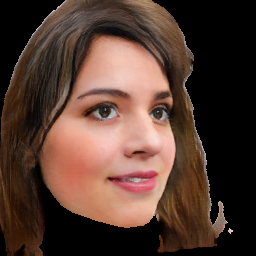

In [3]:
index_id, index_sp, index_ep = 184, 184, 184

shapes, expressions = demo.load_shape_expressions()
sp = shapes[index_sp].unsqueeze(0)
ep = expressions[index_ep].unsqueeze(0)

z = latent_mean[index_id].unsqueeze(0)
theta = torch.Tensor((0,-35,0))

batch_out = demo.run(z=z, sp=sp, ep=ep, theta=theta)
demo.to_image(batch_out)

Running multiple expressions...

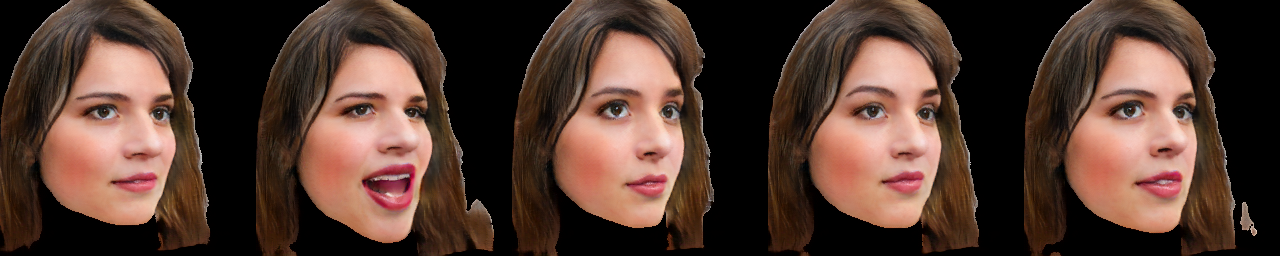

In [4]:
ep_indices = list(range(5))
batches_out = [demo.run(z=z, sp=sp, ep=expressions[ep_index].unsqueeze(0), theta=theta) for ep_index in ep_indices]
demo.to_image(batches_out)

### Pose
Pose can be defined as euler axes (degrees) `theta=(pitch, yaw, roll)`. 

* pitch > 0 $\rightarrow$ looking up
* yaw > 0 $\rightarrow$ looking left
* roll > 0 $\rightarrow$ rotate clockwise

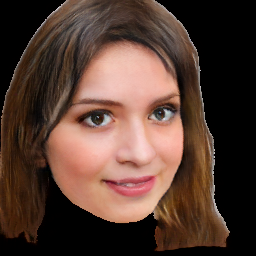

In [5]:
theta = torch.Tensor((-15, -20, 0))

batch_out = demo.run(z=z, sp=sp, ep=ep, theta=theta)
demo.to_image(batch_out)

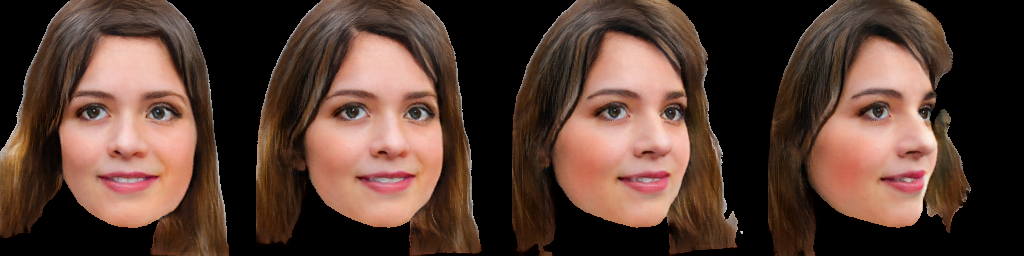

In [6]:
theta_all = [torch.Tensor((0, -t, 0)) for t in 
             np.arange(0, 46, 15)]

batches_out = [demo.run(z=z, sp=sp, ep=ep, theta=t) for t in theta_all]
demo.to_image(batches_out)

## Neural Control: Identity

### Sampling
VariTex controls identity via a latent code `z`. You can generate variants of this identity by resampling the latent code. Execute the cell below multiple times to see different outcomes.

You can change the variable `multiplier` to sample in more/less extreme regions of the learned distribution.

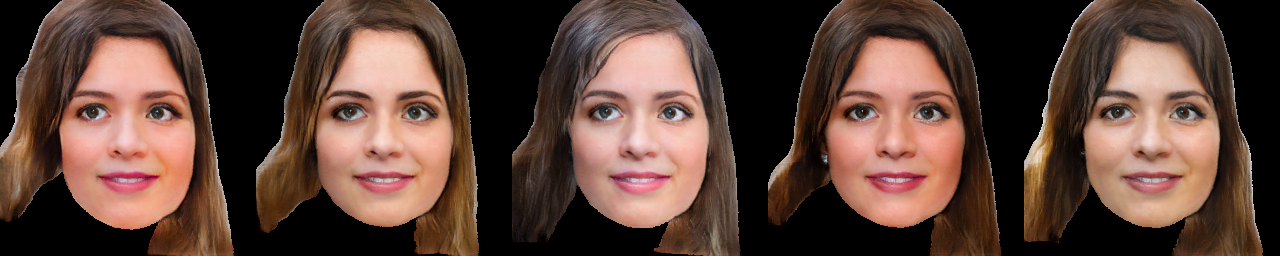

In [7]:
index = 184
multiplier = 1.5
n_samples = 5
z_list = torch.distributions.Normal(latent_mean[index].clone(), latent_std[index].clone() * multiplier).rsample((n_samples,)) 
theta = torch.Tensor((0, 0, 0))

batches_out = [demo.run(z=z_l.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z_l in z_list]
demo.to_image(batches_out)

### Interpolation
Interpolation between two latent codes smoothly transitions from one identity to another.

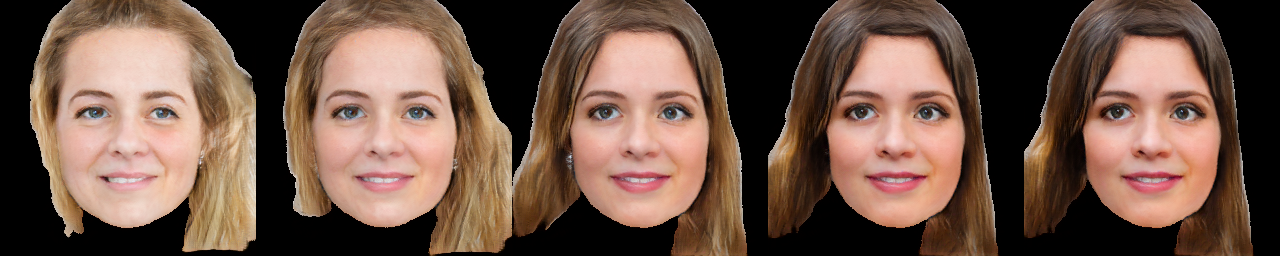

In [8]:
from mutil.np_util import interpolation
n_samples = 5
indexA, indexB = 313, 184

zA, zB = latent_mean[indexA], latent_mean[indexB]
z_interpolated = torch.Tensor(interpolation(n_samples, zA.numpy(), zB.numpy()))

batches_out = [demo.run(z=z.unsqueeze(0), sp=sp, ep=ep, theta=theta) for z in z_interpolated]
demo.to_image(batches_out)